# Generate Simulations

7108314: 100%|██████████| 4186/4186 [2:00:57<00:00,  1.73s/it]    


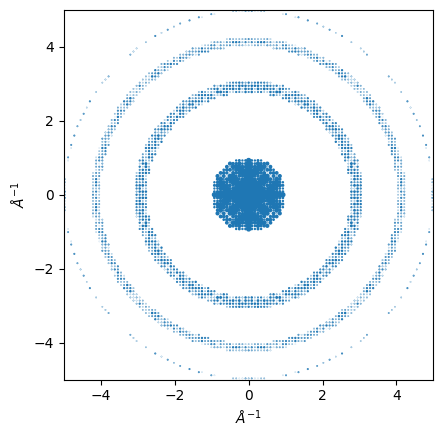

In [ ]:
from orix.crystal_map import Phase
from orix.sampling import get_sample_reduced_fundamental
from diffsims.generators.simulation_generator import SimulationGenerator

cif_file = "/Users/xiaodong/Desktop/simulations/LTA/7108314.cif"
# cif_file = "/home/bubl3932/files/LTA_sim/7108314.cif"

phase = Phase.from_cif(cif_file)

resolution = 0.5 # angular resolution(granularity) of simulation in degrees

# Sample orientations in the symmetry-reduced zone (resolution in degrees)
orientations = get_sample_reduced_fundamental(resolution=0.5, point_group=phase.point_group)

accelerating_voltage = 300  # kV

# Initialize the simulation generator (e.g., setting the accelerating voltage)
generator = SimulationGenerator(accelerating_voltage = accelerating_voltage, approximate_precession = False)

reciprocal_radius = 1/0.2   # 1/Å (i.e. Å⁻¹)
with_direct_beam = False    # Include the direct beam
max_excitation_error = 0.01 # approx 1/thickness of crystal
shape_factor_width = None   # None or float if none then set to max_excitation_error

# Calculate 2D diffraction simulations using the provided phase and orientations
simulations = generator.calculate_diffraction2d(
    phase = phase,
    rotation = orientations,
    reciprocal_radius = reciprocal_radius,
    with_direct_beam = with_direct_beam,
    max_excitation_error = max_excitation_error,
    shape_factor_width = shape_factor_width,
    debye_waller_factors = None,
    show_progressbar = True
)

simulations.plot();

# Add Simulations to Image with or without Background

In [ ]:
import os
from tqdm import tqdm
import h5py
from helper_functions_UB import copy_h5_file, get_next_simulation_folder
from compute_B import compute_B

cell = (11.87250, 11.87250, 11.87250, 90, 90, 90)

# Compute the B matrix from cell parameters
B = compute_B(cell)

# Specify the input HDF5 file with background images
# input_filename = "/home/bubl3932/files/LTA_sim/1081_empty_backgrounds.h5"
input_filename = "/Users/xiaodong/Desktop/simulations/LTA/4186_empty_backgrounds.h5"

base_dir = os.path.dirname(input_filename)

# 1. Create a new simulation folder
new_sim_folder = get_next_simulation_folder(base_dir)

# 2. Copy the original file to the new simulation folder
output_filename = os.path.join(new_sim_folder, "sim.h5")
copy_h5_file(input_filename, output_filename)

# 3. Process the simulation images.
in_plane_angle = 180        # set to correspond to geometry file definitions of xs and ss
sigma = 1                   # spread of the  in pixels
calibration = 0.002844      # calculated based on geometry (use script to calculate)
fast = False                # use fast if no subpixel accuracy is needed
normalize = True            # normalize the intensities of simulated spots
fast_clip_threshold = 0     # threshold for clipping the fast simulation
intensity_scale = 10000     # scale the intensity of the simulated spots

with h5py.File(output_filename, "r+") as data:
    images = data["entry"]["data"]["images"]
    orientation_matrices = data["entry"]["data"].require_dataset(
        "simulation_orientation_matrices", 
        shape=(images.shape[0], 3, 3), 
        dtype=float
    )
    shape = images.shape[-2:]
    
    beam_pos = (shape[0] // 2, shape[1] // 2)

    for i in tqdm(range(images.shape[0]), desc="Processing images"):
        img = simulations.irot[i].get_diffraction_pattern(
            shape=shape,
            direct_beam_position=beam_pos,
            in_plane_angle=in_plane_angle,  
            sigma=sigma,
            calibration=calibration,
            fast=fast,
            normalize=normalize,
            fast_clip_threshold=fast_clip_threshold
        )
        img = (img * intensity_scale).astype(images.dtype)
        images[i] += img
        orientation_matrices_i = simulations.rotations[i].to_matrix().squeeze()
        
        orientation_matrices[i] = B @ orientation_matrices_i 
print("Processing complete. Updated file saved at:", output_filename)
import os

# Define your variables
in_plane_angle = 180        # set to correspond to geometry file definitions of xs and ss
sigma = 1                   # spread of the in pixels
calibration = 0.002844      # calculated based on geometry (use script to calculate)
fast = False                # use fast if no subpixel accuracy is needed
normalize = True            # normalize the intensities of simulated spots
fast_clip_threshold = 0     # threshold for clipping the fast simulation
intensity_scale = 10000     # scale the intensity of the simulated spots

# Specify the folder and file name
folder_path = r"/path/to/your/specified/folder"  # Change to your folder path
filename = "variables.txt"

# Create the folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# Construct the full file path
file_path = os.path.join(folder_path, filename)

# Write variables and their values to the file
with open(file_path, "w") as file:
    file.write(f"in_plane_angle = {in_plane_angle}\n")
    file.write(f"sigma = {sigma}\n")
    file.write(f"calibration = {calibration}\n")
    file.write(f"fast = {fast}\n")
    file.write(f"normalize = {normalize}\n")
    file.write(f"fast_clip_threshold = {fast_clip_threshold}\n")
    file.write(f"intensity_scale = {intensity_scale}\n")

print(f"Variables have been written to {file_path}")

# Read back the entire dataset into memory
with h5py.File(output_filename, "r") as data:
    orientation_matrices_np = data["entry"]["data"]["simulation_orientation_matrices"][:]
output_sol = os.path.join(new_sim_folder, "orientation_matrices.sol")

# Write orientation matrices to a .sol file
with open(output_sol, "w") as sol_file:
    for i, matrix in enumerate(orientation_matrices_np):
        # Flatten the 3x3 matrix (row-major order)
        # Each number is formatted with a sign (+ or -) and 7 decimal places.
        line = " ".join(f"{num:+.7f}" for num in matrix.flatten())
        sol_file.write(f"{output_filename} //{i} " + line + " 0.000 0.000 cP\n")

Processing images: 100%|██████████| 4186/4186 [01:34<00:00, 44.38it/s]


Processing complete. Updated file saved at: /Users/xiaodong/Desktop/simulations/LTA/simulation-33/sim.h5


# Integration from .sol file

In [ ]:
from gandalf_iterator import gandalf_iterator

geomfile_path = "/Users/xiaodong/Desktop/simulations/LTA/LTAsim.geom"
cellfile_path = "/Users/xiaodong/Desktop/simulations/LTA/LTA.cell"
input_path =   "/Users/xiaodong/Desktop/simulations/LTA/simulation-33"

# geomfile_path = "/home/bubl3932/files/LTA_sim/LTAsim.geom"
# cellfile_path = "/home/bubl3932/files/LTA_sim/LTA.cell"
# input_path =   "/home/bubl3932/files/LTA_sim/simulation-22"

output_file_base = "LTAsim_from_file"

num_threads = 8
x, y = 512.5, 512.5
step_size = 0.5
layers = 0
# input_sol_file = "/home/bubl3932/files/LTA_sim/simulation-22/orientation_matrices.sol"
input_sol_file = "/Users/xiaodong/Desktop/simulations/LTA/simulation-33/orientation_matrices.sol"

extra_flags=[
# PEAKFINDING
"--no-revalidate",
"--no-half-pixel-shift",
"--peaks=peakfinder9",
"--min-snr=1",
"--min-snr-biggest-pix=1",
"--min-sig=3",
"--local-bg-radius=3",
# INDEXING
"--indexing=file",
f"--fromfile-input-file={input_sol_file}",
"--no-check-cell",
"--no-check-peaks",
"--no-retry",
"--no-refine",
# INTEGRATION
"--integration=rings",
"--int-radius=4,5,9",
# OUTPUT
"--no-non-hits-in-stream",
"--fix-profile-radius=70000000",
]

"""Examples of extra flags(see crystfel documentation https://www.desy.de/~twhite/crystfel/manual-indexamajig.html):"""

""" Basic options
"--highres=n",
"--no-image-data",
"""

""" Peakfinding
"--peaks=cxi",
"--peak-radius=inner,middle,outer",
"--min-peaks=n",
"--median-filter=n",
"--filter-noise",
"--no-revalidate",
"--no-half-pixel-shift",

"--peaks=peakfinder9",
"--min-snr=1",
"--min-snr-peak-pix=6",
"--min-snr-biggest-pix=1",
"--min-sig=9",
"--min-peak-over-neighbour=5",
"--local-bg-radius=5",

"--peaks=peakfinder8",
"--threshold=45",
"--min-snr=3",
"--min-pix-count=3",
"--max-pix-count=500",
"--local-bg-radius=9",
"--min-res=30",
"--max-res=500",
"""

""" Indexing
"--indexing=xgandalf",

"--tolerance=tol"
"--no-check-cell",
"--no-check-peaks",
"--multi",
"--no-retry",
"--no-refine",

"--xgandalf-sampling-pitch=n"
"--xgandalf-grad-desc-iterations=n"
"--xgandalf-tolerance=n"
"--xgandalf-no-deviation-from-provided-cell"
"--xgandalf-max-lattice-vector-length=n"
"--xgandalf-min-lattice-vector-length=n"
"--xgandalf-max-peaks=n"
"--xgandalf-fast-execution"
"""

""" Integration
"--integration=rings",
"--int-radius=4,5,10",
"--push-res=n",
"--overpredict",
"--cell-parameters-only",
"""

""" Output
"--no-non-hits-in-stream",
"--no-peaks-in-stream",
"--no-refls-in-stream",
"--serial-offset
"""

gandalf_iterator(x, y, geomfile_path, cellfile_path, input_path, output_file_base, num_threads, step_size, layers, extra_flags=extra_flags)


# Index using XGANDALF and Integration using rings

In [10]:
from gandalf_iterator import gandalf_iterator

geomfile_path = "/Users/xiaodong/Desktop/simulations/LTA/LTAsim.geom"
cellfile_path = "/Users/xiaodong/Desktop/simulations/LTA/LTA.cell"
input_path =   "/Users/xiaodong/Desktop/simulations/LTA/simulation-33"
output_file_base = "LTAsim_xgandalf"

num_threads = 8
x, y = 512.5, 512.5
step_size = 0.01
layers = 0
extra_flags=[
# PEAKFINDING
"--no-revalidate",
"--no-half-pixel-shift",
"--peaks=peakfinder9",
"--min-snr=1",
"--min-snr-biggest-pix=1",
"--min-sig=3",
"--local-bg-radius=10",
# INDEXING
"--indexing=xgandalf",
# "--tolerance=10,10,10,5",
"--no-refine",
"--xgandalf-sampling-pitch=5",
"--xgandalf-grad-desc-iterations=1",
"--xgandalf-tolerance=0.02",
"--xgandalf-no-deviation-from-provided-cell",
# INTEGRATION
"--integration=rings",
"--int-radius=4,5,9",
"--fix-profile-radius=70000000",
# OUTPUT
"--no-non-hits-in-stream",
]

"""Examples of extra flags(see crystfel documentation https://www.desy.de/~twhite/crystfel/manual-indexamajig.html):"""

""" Basic options
"--highres=n",
"--no-image-data",
"""

""" Peakfinding
"--peaks=cxi",
"--peak-radius=inner,middle,outer",
"--min-peaks=n",
"--median-filter=n",
"--filter-noise",
"--no-revalidate",
"--no-half-pixel-shift",

"--peaks=peakfinder9",
"--min-snr=1",
"--min-snr-peak-pix=6",
"--min-snr-biggest-pix=1",
"--min-sig=9",
"--min-peak-over-neighbour=5",
"--local-bg-radius=5",

"--peaks=peakfinder8",
"--threshold=45",
"--min-snr=3",
"--min-pix-count=3",
"--max-pix-count=500",
"--local-bg-radius=9",
"--min-res=30",
"--max-res=500",
"""

""" Indexing
"--indexing=xgandalf",

"--tolerance=tol"
"--no-check-cell",
"--no-check-peaks",
"--multi",
"--no-retry",
"--no-refine",

"--xgandalf-sampling-pitch=n"
"--xgandalf-grad-desc-iterations=n"
"--xgandalf-tolerance=n"
"--xgandalf-no-deviation-from-provided-cell"
"--xgandalf-max-lattice-vector-length=n"
"--xgandalf-min-lattice-vector-length=n"
"--xgandalf-max-peaks=n"
"--xgandalf-fast-execution"
"""

""" Integration
"--fix-profile-radius=n",
"--fix-divergence=n",
"--integration=rings",
"--int-radius=4,5,10",
"--push-res=n",
"--overpredict",
"--cell-parameters-only",
"""

""" Output
"--no-non-hits-in-stream",
"--no-peaks-in-stream",
"--no-refls-in-stream",
"--serial-offset
"""

gandalf_iterator(x, y, geomfile_path, cellfile_path, input_path, output_file_base, num_threads, step_size, layers, extra_flags=extra_flags)


'list.lst' has been created with 1 entries at /Users/xiaodong/Desktop/simulations/LTA/simulation-33/list.lst


Processing XY pairs:   0%|          | 0/1 [00:00<?, ?it/s]

Running for x=-512.5, y=-512.5


This is what I understood your unit cell to be:
cubic P, right handed.
a      b      c            alpha   beta  gamma
 11.87  11.87  11.87 A     90.00  90.00  90.00 deg
List of indexing methods:
   0: xgandalf-nolatt-cell      (xgandalf using cell parameters as prior information)
Indexing parameters:
                  Check unit cell parameters: on
                        Check peak alignment: on
                   Refine indexing solutions: off
 Multi-lattice indexing ("delete and retry"): off
                              Retry indexing: on


Not able to fit found basis to sample basis! 
           1  9.56155e-05  -1.4763e-05
-9.55274e-05     0.999999 -0.000315516
  9.2672e-05  0.000308122     0.108179
Not able to fit found basis to sample basis! 
   0.995506   0.0304247 -0.00893538
 -0.0352522    0.908815   -0.201829
  -0.031602    -0.10632   -0.186615
Not able to fit found basis to sample basis! 
  0.994455  0.0280857 -0.0236981
-0.0317108     0.9523  0.0379159
 -0.041938 -0.0528613  -0.128395
Not able to fit found basis to sample basis! 
  0.994455  0.0280857 -0.0236981
-0.0317108     0.9523  0.0379159
 -0.041938 -0.0528613  -0.128395
Not able to fit found basis to sample basis! 
           1  4.27091e-05  2.04332e-05
-4.27165e-05            1 -6.91311e-05
 6.23344e-05  9.99581e-05    0.0353396
Not able to fit found basis to sample basis! 
   0.99538  0.0322663 -0.0112943
 -0.030643   0.985132  0.0805138
 0.0291861 -0.0323118 -0.0646238
Not able to fit found basis to sample basis! 
    0.996044 -7.45058e-09  2.98023e-08


10 images processed, 10 hits (100.0%), 10 indexable (100.0% of hits, 100.0% overall), 10 crystals, 2.0 images/sec.


Not able to fit found basis to sample basis! 
           1 -1.88623e-05 -4.15591e-06
 1.88855e-05     0.999999    0.0004329
 9.42232e-05  6.88592e-05   -0.0554275
Not able to fit found basis to sample basis! 
           1 -7.19237e-06  1.73734e-05
 7.16327e-06            1  0.000297996
 9.79152e-05   5.8573e-05   -0.0574271
Not able to fit found basis to sample basis! 
    0.999999 -2.43402e-05  2.99414e-05
 2.43447e-05            1  5.74242e-06
 3.63747e-05 -6.18763e-05   -0.0573151
Not able to fit found basis to sample basis! 
    0.997284 -1.49012e-08   -0.0218516
 2.98023e-08     0.987793   8.9407e-08
   -0.024351   -0.0788016   -0.0614245
Not able to fit found basis to sample basis! 
    0.997284 -1.49012e-08   -0.0218516
 2.98023e-08     0.987793   8.9407e-08
   -0.024351   -0.0788016   -0.0614245
Not able to fit found basis to sample basis! 
           1  0.000494228  2.42446e-05
-0.000494175     0.999999  2.13379e-05
-4.73339e-05  2.08798e-05    -0.166481
Not able to fit found 

27 images processed, 27 hits (100.0%), 22 indexable (81.5% of hits, 81.5% overall), 22 crystals, 3.2 images/sec.
51 images processed, 51 hits (100.0%), 46 indexable (90.2% of hits, 90.2% overall), 46 crystals, 4.7 images/sec.


Not able to fit found basis to sample basis! 
           1  0.000127765  1.36299e-05
-0.000127688            1  0.000335328
 0.000126572  0.000108083    0.0509241
Not able to fit found basis to sample basis! 
  0.979545  -0.157924  0.0310861
  0.152633   0.978849   0.065632
-0.0020973  0.0181796 -0.0282468
Not able to fit found basis to sample basis! 
    0.4261   0.895726  0.0620438
 -0.893384   0.427753 -0.0249934
 0.0431095  0.0208534 -0.0287747
Not able to fit found basis to sample basis! 
    0.4261   0.895726  0.0620438
 -0.893384   0.427753 -0.0249934
 0.0431095  0.0208534 -0.0287747
Not able to fit found basis to sample basis! 
           1  0.000123989 -8.99236e-05
-0.000124224     0.999999  0.000110483
 7.93207e-06  9.13627e-05   -0.0164592
Not able to fit found basis to sample basis! 
  0.979698   -0.15695 -0.0247657
  0.151709   0.979016 -0.0637755
 0.0470616 0.00321305 -0.0499164
Not able to fit found basis to sample basis! 
  0.423907   0.896787 -0.0590046
  0.894465  -0.

60 images processed, 60 hits (100.0%), 54 indexable (90.0% of hits, 90.0% overall), 54 crystals, 1.6 images/sec.
86 images processed, 86 hits (100.0%), 76 indexable (88.4% of hits, 88.4% overall), 76 crystals, 4.9 images/sec.


Not able to fit found basis to sample basis! 
           1  8.97353e-08  5.96046e-08
-3.05133e-08            1   -1.527e-05
-0.000132963  0.000105306     0.140085
Not able to fit found basis to sample basis! 
    0.995543  9.40636e-08 -1.49012e-08
-5.96046e-08     0.990908   -0.0942081
   0.0314706   -0.0142366    -0.184731
Not able to fit found basis to sample basis! 
    0.995543  9.40636e-08 -1.49012e-08
-5.96046e-08     0.990908   -0.0942081
   0.0314706   -0.0142366    -0.184731


91 images processed, 91 hits (100.0%), 81 indexable (89.0% of hits, 89.0% overall), 81 crystals, 1.0 images/sec.


Not able to fit found basis to sample basis! 
           1  9.04668e-05  3.44589e-05
-9.05134e-05            1 -1.79633e-05
 -1.9662e-05  1.70138e-05   -0.0544473
Not able to fit found basis to sample basis! 
   0.996507  0.00840024 -0.00415127
  -0.007847    0.995125 -0.00813686
 -0.0105909  -0.0015971   -0.212582
Not able to fit found basis to sample basis! 
   0.996507  0.00840024 -0.00415127
  -0.007847    0.995125 -0.00813686
 -0.0105909  -0.0015971   -0.212582


106 images processed, 106 hits (100.0%), 91 indexable (85.8% of hits, 85.8% overall), 91 crystals, 2.9 images/sec.
130 images processed, 130 hits (100.0%), 114 indexable (87.7% of hits, 87.7% overall), 114 crystals, 4.8 images/sec.
147 images processed, 147 hits (100.0%), 131 indexable (89.1% of hits, 89.1% overall), 131 crystals, 3.3 images/sec.
160 images processed, 160 hits (100.0%), 142 indexable (88.8% of hits, 88.8% overall), 142 crystals, 2.5 images/sec.
179 images processed, 179 hits (100.0%), 160 indexable (89.4% of hits, 89.4% overall), 160 crystals, 3.6 images/sec.
191 images processed, 191 hits (100.0%), 172 indexable (90.1% of hits, 90.1% overall), 172 crystals, 2.4 images/sec.
214 images processed, 214 hits (100.0%), 191 indexable (89.3% of hits, 89.3% overall), 191 crystals, 4.5 images/sec.
235 images processed, 235 hits (100.0%), 212 indexable (90.2% of hits, 90.2% overall), 212 crystals, 4.0 images/sec.
257 images processed, 257 hits (100.0%), 234 indexable (91.1% of h

Not able to fit found basis to sample basis! 
    0.999994   0.00349547 -0.000148622
 -0.00349552     0.999993  0.000693601
-9.78742e-05  0.000189604    -0.137966
Not able to fit found basis to sample basis! 
    0.99255   0.0414216  -0.0399235
 -0.0383911    0.971821     0.14938
 -0.0154863 0.000952119   -0.149196
Not able to fit found basis to sample basis! 
   0.992716   0.0312426  -0.0406009
 -0.0293544    0.976947    0.129885
 -0.0149323 -0.00184048    -0.14866
Not able to fit found basis to sample basis! 
   0.992716   0.0312426  -0.0406009
 -0.0293544    0.976947    0.129885
 -0.0149323 -0.00184048    -0.14866


355 images processed, 355 hits (100.0%), 329 indexable (92.7% of hits, 92.7% overall), 329 crystals, 3.6 images/sec.


Not able to fit found basis to sample basis! 
           1  -3.1665e-08  2.79397e-08
 3.77186e-08     0.999998 -0.000397399
  1.3961e-05  3.63868e-05      0.25712
Not able to fit found basis to sample basis! 
   0.992716   0.0312426  -0.0406009
 -0.0293544    0.976947    0.129885
 -0.0149323 -0.00184048    -0.14866
Not able to fit found basis to sample basis! 
   0.992716   0.0312426  -0.0406009
 -0.0293544    0.976947    0.129885
 -0.0149323 -0.00184048    -0.14866


373 images processed, 373 hits (100.0%), 347 indexable (93.0% of hits, 93.0% overall), 347 crystals, 3.6 images/sec.
395 images processed, 395 hits (100.0%), 369 indexable (93.4% of hits, 93.4% overall), 369 crystals, 4.3 images/sec.
419 images processed, 419 hits (100.0%), 393 indexable (93.8% of hits, 93.8% overall), 393 crystals, 4.5 images/sec.
441 images processed, 441 hits (100.0%), 413 indexable (93.7% of hits, 93.7% overall), 413 crystals, 4.3 images/sec.
466 images processed, 466 hits (100.0%), 438 indexable (94.0% of hits, 94.0% overall), 438 crystals, 4.8 images/sec.
487 images processed, 487 hits (100.0%), 459 indexable (94.3% of hits, 94.3% overall), 459 crystals, 4.1 images/sec.
510 images processed, 510 hits (100.0%), 482 indexable (94.5% of hits, 94.5% overall), 482 crystals, 4.5 images/sec.
531 images processed, 531 hits (100.0%), 503 indexable (94.7% of hits, 94.7% overall), 503 crystals, 4.2 images/sec.
552 images processed, 552 hits (100.0%), 523 indexable (94.7% of

Not able to fit found basis to sample basis! 
          -1 -1.51003e-05 -0.000107432
-1.50806e-05            1  3.92739e-06
 4.15659e-05   7.9195e-06     0.126487
Not able to fit found basis to sample basis! 
   -0.995018    0.0492354  0.000788406
   0.0507898     0.994054 -0.000513352
   0.0036986    0.0379818   0.00496605
Not able to fit found basis to sample basis! 
  -0.997039  -0.0183067 -0.00543371
 -0.0173888    0.993166  0.00693039
  0.0126296   0.0364509  -0.0106737


2625 images processed, 2625 hits (100.0%), 2595 indexable (98.9% of hits, 98.9% overall), 2595 crystals, 3.0 images/sec.
2647 images processed, 2647 hits (100.0%), 2616 indexable (98.8% of hits, 98.8% overall), 2616 crystals, 4.2 images/sec.
2669 images processed, 2669 hits (100.0%), 2638 indexable (98.8% of hits, 98.8% overall), 2638 crystals, 4.1 images/sec.
2690 images processed, 2690 hits (100.0%), 2659 indexable (98.8% of hits, 98.8% overall), 2659 crystals, 3.8 images/sec.
2713 images processed, 2713 hits (100.0%), 2682 indexable (98.9% of hits, 98.9% overall), 2682 crystals, 4.5 images/sec.
2731 images processed, 2731 hits (100.0%), 2700 indexable (98.9% of hits, 98.9% overall), 2700 crystals, 3.6 images/sec.
2753 images processed, 2753 hits (100.0%), 2721 indexable (98.8% of hits, 98.8% overall), 2721 crystals, 4.3 images/sec.
2778 images processed, 2778 hits (100.0%), 2746 indexable (98.8% of hits, 98.8% overall), 2746 crystals, 5.0 images/sec.
2802 images processed, 2802 hits

Not able to fit found basis to sample basis! 
           1  5.53923e-05 -4.16785e-05
-5.52866e-05     0.999999  0.000456997
 5.34537e-05 -9.41609e-05    -0.083657
Not able to fit found basis to sample basis! 
  0.361117    0.92377 0.00458981
  0.922103  -0.359363 -0.0402885
-0.0348561  0.0621642 -0.0417577
Not able to fit found basis to sample basis! 
  -0.992727 2.98023e-08 5.96046e-08
4.47035e-08    0.988006  -0.0532969
0.000919253  -0.0571892   -0.364312
Not able to fit found basis to sample basis! 
  -0.992727 2.98023e-08 5.96046e-08
4.47035e-08    0.988006  -0.0532969
0.000919253  -0.0571892   -0.364312


3539 images processed, 3539 hits (100.0%), 3504 indexable (99.0% of hits, 99.0% overall), 3504 crystals, 4.6 images/sec.
3560 images processed, 3560 hits (100.0%), 3525 indexable (99.0% of hits, 99.0% overall), 3525 crystals, 4.1 images/sec.
3583 images processed, 3583 hits (100.0%), 3548 indexable (99.0% of hits, 99.0% overall), 3548 crystals, 4.5 images/sec.
3607 images processed, 3607 hits (100.0%), 3572 indexable (99.0% of hits, 99.0% overall), 3572 crystals, 4.7 images/sec.
3630 images processed, 3630 hits (100.0%), 3595 indexable (99.0% of hits, 99.0% overall), 3595 crystals, 4.5 images/sec.
3654 images processed, 3654 hits (100.0%), 3619 indexable (99.0% of hits, 99.0% overall), 3619 crystals, 4.6 images/sec.
3678 images processed, 3678 hits (100.0%), 3643 indexable (99.0% of hits, 99.0% overall), 3643 crystals, 4.8 images/sec.
3701 images processed, 3701 hits (100.0%), 3666 indexable (99.1% of hits, 99.1% overall), 3666 crystals, 4.5 images/sec.
3724 images processed, 3724 hits

Not able to fit found basis to sample basis! 
    0.999999   0.00129557  0.000112673
 -0.00129575     0.999998  0.000751387
-3.97209e-05 -0.000140802   -0.0521423
Not able to fit found basis to sample basis! 
  0.991341 -0.0735568 -0.0178526
 0.0728738   0.967514  -0.134962
0.00140941  -0.120473  -0.293088
Not able to fit found basis to sample basis! 
  0.991341 -0.0735568 -0.0178526
 0.0728738   0.967514  -0.134962
0.00140941  -0.120473  -0.293088


4101 images processed, 4101 hits (100.0%), 4063 indexable (99.1% of hits, 99.1% overall), 4063 crystals, 2.0 images/sec.
4124 images processed, 4124 hits (100.0%), 4084 indexable (99.0% of hits, 99.0% overall), 4084 crystals, 4.5 images/sec.
4148 images processed, 4148 hits (100.0%), 4108 indexable (99.0% of hits, 99.0% overall), 4108 crystals, 4.6 images/sec.
4167 images processed, 4167 hits (100.0%), 4127 indexable (99.0% of hits, 99.0% overall), 4127 crystals, 3.5 images/sec.
Waiting for the last patterns to be processed...
4182 images processed, 4182 hits (100.0%), 4142 indexable (99.0% of hits, 99.0% overall), 4142 crystals, 2.9 images/sec.


Not able to fit found basis to sample basis! 
   0.999998  0.00191199 8.19698e-05
 0.00191216   -0.999998 6.72603e-05
0.000495156 0.000168063   -0.266004
Not able to fit found basis to sample basis! 
   0.999739  -0.0137114  0.00150171
 -0.0137536   -0.999721  0.00410259
-0.00571138  0.00403094   -0.241173
Not able to fit found basis to sample basis! 
  -0.51685   0.257306  -0.408257
 -0.481249  -0.318965  -0.408255
-0.0356002   0.576241   -0.40823
Not able to fit found basis to sample basis! 
  -0.51685   0.257306  -0.408257
 -0.481249  -0.318965  -0.408255
-0.0356002   0.576241   -0.40823


Final: 4186 images processed, 4186 hits (100.0%), 4144 indexable (99.0% of hits, 99.0% overall), 4144 crystals.
Processing XY pairs: 100%|██████████| 1/1 [16:46<00:00, 1006.54s/it]


In [ ]:
import os 
from run_partialator_and_convert import run_partialator_and_convert
from convert_hkl_crystfel_to_shelx import convert_hkl_crystfel_to_shelx

stream_file = "/Users/xiaodong/Desktop/simulations/LTA/simulation-29/LTAsim_from_file_-512.5_-512.5.stream" # Stream file to be merged
pointgroup = "m-3m"  # Point group of the crystal
num_threads = 8
iterations = 5

output_dir = run_partialator_and_convert(
    stream_file,
    pointgroup=pointgroup,
    num_threads=num_threads,
    iterations=iterations,
)

if output_dir is not None:
    print("All done. Results are in:", output_dir)

convert_hkl_crystfel_to_shelx(os.path.join(output_dir, "crystfel.hkl"))
